In [1]:
! pip install easydict

  Created wheel for easydict: filename=easydict-1.9-cp36-none-any.whl size=6349 sha256=c778c7555183559d443df208ec404d4df48f627bd0884c1c15c1d714c16b1dc3
  Stored in directory: /tmp/.cache/pip/wheels/9a/88/ec/085d92753646b0eda1b7df49c7afe51a6ecc496556d3012e2e
Successfully built easydict


In [2]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import scipy as sp
import scipy.misc
import ast
import os
import sys
sys.path.insert(0, os.path.abspath('/kaggle/input/ivanfashionablecode/Design-Inspiration-from-Generative-Networks-master/'))

import skimage
import imageio
from itertools import islice
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from math import log10
import easydict

from IPython.display import clear_output
from IPython.core.debugger import set_trace

from torchvision.transforms import Resize, ToTensor, Normalize
import re
import torch
from torch import nn 
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from skimage import segmentation

from tqdm import tqdm_notebook

from shutil import rmtree
import json
from IPython.display import clear_output
from torch import autograd

from skimage import io
from skimage.feature import canny
from skimage.morphology import dilation, disk
from skimage.color import rgb2gray

from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from utils import vis_batch, collate_fn, tensor2numpy
from encoder_decoder import MaskDecoder, MaskEncoder



In [ ]:
!cp '/kaggle/input/ivanfashionablecode/Design-Inspiration-from-Generative-Networks-master/README.md' .
from IPython.display import FileLinks

FileLinks('.')

In [3]:
plt.rcParams['image.cmap'] = 'gray'

In [4]:
device = 'cuda'

In [5]:
import os
import skimage
import imageio
from PIL import Image
from skimage import io
import numpy as np
from torchvision.transforms import Resize, ToTensor, Normalize
import torch
import ast
from utils import image2edges, edges2mask, tensor2numpy
from torch.utils.data import Dataset

class FashionEdgesDataset(Dataset):
    def __init__(self, 
                 images_fold, 
                 attr_file=None, 
                 check_corrupted=False,
                 return_mask=True):
        
        self.corrupted_images = set()
        self.check_corrupted = check_corrupted
        self.images_fold = images_fold
        self.return_mask = return_mask
        
        if attr_file is not None:
            images2attr_dict = {}
            with open(attr_file, 'r') as f:
                dicts = f.readlines()
            for d in tqdm_notebook(dicts):
                dct = ast.literal_eval(d)
                image_name = dct['image']
                
                if check_corrupted:
                    img = Image.open(os.path.join(self.images_fold, image_name))
                    if not self._is_appropriate(np.array(img)):
                        self.corrupted_images.add(image_name)
                        continue

                images2attr_dict[image_name] = dct['attributes']
                
            self.images2attr = images2attr_dict
            self.images_names = list(images2attr_dict.keys())
        else:
            self.images_names = os.listdir(self.images_fold)
    
    def _is_appropriate(self, img, thresh = 10):
    
        return np.all(img[:thresh,:thresh] == 255)
    
    def __getitem__(self, idx):
        
        image_name = self.images_names[idx]
        img = Image.open(os.path.join(self.images_fold, image_name))#.convert('RGB')        
        if not self.check_corrupted and not self._is_appropriate(np.array(img)):
            return None
        
        img = Resize((128, 128))(img)
        
        img = ToTensor()(img)
        if img.shape[0] > 3:
            img = img[:3]
        
        img_np = tensor2numpy(img)

        edges_np = image2edges(img_np)
        edges = torch.tensor(edges_np, dtype=torch.float32).unsqueeze(0)
        if self.return_mask:
            mask = edges2mask(edges_np)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            return edges, mask, img
        else:
            return edges, img   

    def __len__(self):
        return len(self.images_names)


# Autoencoder clusterization

In [6]:
#from dataset import FashionEdgesDataset

all_set = FashionEdgesDataset('/kaggle/input/fashionismyprofession/cp-vton/')
train_set, val_set = torch.utils.data.random_split(all_set, [
    int(len(all_set) * 0.9),
    len(all_set) - int(len(all_set) * 0.9)
])
training_data_loader = DataLoader(dataset=train_set,
                                  batch_size=64, 
                                  collate_fn=collate_fn,
                                  num_workers=2,
                                  shuffle=True)
validation_data_loader = DataLoader(dataset=val_set,
                                  batch_size=64, 
                                  collate_fn=collate_fn,
                                  num_workers=2,
                                  shuffle=False)

In [7]:
encoder = MaskEncoder(128).to(device)
decoder = MaskDecoder(128).to(device)
opt = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

In [ ]:
from IPython.display import clear_output

criterionL2 = nn.MSELoss().to(device)
n_epochs = 10
n_show = 5

all_train_loss = []
all_val_loss = []

for epoch in range(n_epochs):
    train_loss = 0
    for _, mask in tqdm_notebook(training_data_loader):
        mask = mask.to(device)
        autoencode_mask = decoder(encoder(mask))
        loss = criterionL2(mask, autoencode_mask)
        train_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    train_loss /= len(training_data_loader)
    all_train_loss.append(train_loss)
    
    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }, '/kaggle/working/encoder_decoder_{0}.pt'.format(epoch))
    
    val_loss = 0
    for _, mask in tqdm_notebook(validation_data_loader):
        mask = mask.to(device)
        autoencode_mask = decoder(encoder(mask))
        loss = criterionL2(mask, autoencode_mask)
        val_loss += loss.item()
    
    val_loss /= len(validation_data_loader)
    all_val_loss.append(val_loss)
    
    clear_output()
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_loss, label='train')
    plt.plot(all_val_loss, label='val')
    plt.grid(ls=':')
    plt.legend()
    plt.show()
    
    for _, mask in validation_data_loader:
        draw_batch = mask[:n_show].to(device)
        break
    recover_batch = decoder(encoder(draw_batch))
    
    plt.figure(figsize=(15, 3))
    for i in range(n_show):
        plt.subplot(1, n_show, i + 1)
        plt.imshow(draw_batch[i][0].cpu().data.numpy())
    plt.show()
    
    plt.figure(figsize=(15, 3))
    for i in range(n_show):
        plt.subplot(1, n_show, i + 1)
        plt.imshow(recover_batch[i][0].cpu().data.numpy())
    plt.show()

In [12]:
! ls ../input

fashionismyprofession  fashionweights  ivanfashionablecode


In [15]:
state_dict = torch.load('/kaggle/input/fashionweights/encoder_decoder_9.pt')
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

<All keys matched successfully>

In [16]:
all_data_loader = DataLoader(dataset=all_set, batch_size=64, collate_fn=collate_fn, num_workers=2, shuffle=False)
all_encoded = []
for _, batch in tqdm_notebook(all_data_loader):
    batch = batch.to(device)
    encoded = encoder(batch).cpu().data.numpy()
    all_encoded.append(encoded)
all_encoded = np.vstack(all_encoded)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
from sklearn.cluster import DBSCAN

clst = DBSCAN(eps=9)
labels = clst.fit_predict(all_encoded)

In [20]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

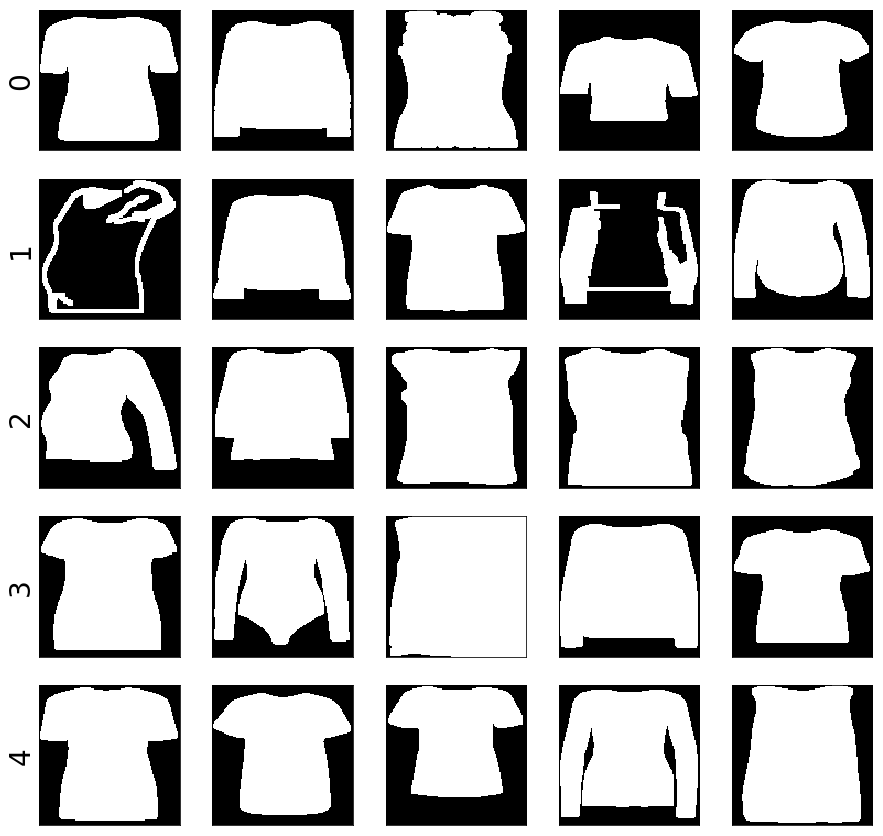

In [31]:
plt.figure(figsize=(15, 15))
for l in np.unique(labels)[1:]:
    indices = np.where(labels == l)[0]
    j = -1
    for i in range(5):
        j += 1
        plt.subplot(5, 5, 5 * l + i + 1)
        if i == 0:
            plt.ylabel('{}'.format(l), fontsize=28)
        while j < len(indices) and all_set[indices[j]] is None:
            j +=1
        plt.imshow(all_set[indices[j]][1].cpu().data.numpy()[0])
        if j == len(indices):
            break
        plt.xticks([], [])
        plt.yticks([], [])
    if l == 4:
        break
plt.show()

# Classic CV clusterization

In [32]:
import cv2
import numpy as np

def get_shape_descriptor(img):
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    moments = cv2.moments(contours[0])

    cx = int(moments['m10']/moments['m00'])
    cy = int(moments['m01']/moments['m00'])
    w, h = img.shape

    translation_matrix = np.float32([ [1,0,h//2 -cx], [0,1,w//2 -cy] ])
    img_centered = cv2.warpAffine(img, translation_matrix, (w, h), borderValue=255)

    img_gray = cv2.bitwise_not(img_centered).astype(np.float32)

    #--- the following holds the square root of the sum of squares of the image dimensions ---
    #--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---
    value = np.sqrt(((img_gray.shape[0]/2.0)**2.0)+((img_gray.shape[1]/2.0)**2.0))

    polar_image = cv2.linearPolar(img_gray, (img_gray.shape[0]//2, img_gray.shape[1]//2), value, cv2.WARP_FILL_OUTLIERS)
    shape_descriptor = polar_image.mean(axis=1)
    
    return shape_descriptor

In [33]:
all_data_loader = DataLoader(dataset=all_set, batch_size=64, collate_fn=collate_fn,  shuffle=False)
all_encoded = []
for _, batch in tqdm_notebook(all_data_loader):
    for img in batch.cpu().data.numpy():
        img = (255 * (1 - img[0])).astype('uint8')
        all_encoded.append(get_shape_descriptor(img))
all_encoded = np.vstack(all_encoded)
all_encoded = all_encoded / 255
all_encoded = (all_encoded - all_encoded.mean(axis=0)) / all_encoded.std(axis=0)  # normalization by each feature

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
from sklearn.cluster import DBSCAN

clst = DBSCAN(eps=6)
labels = clst.fit_predict(all_encoded)

In [41]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

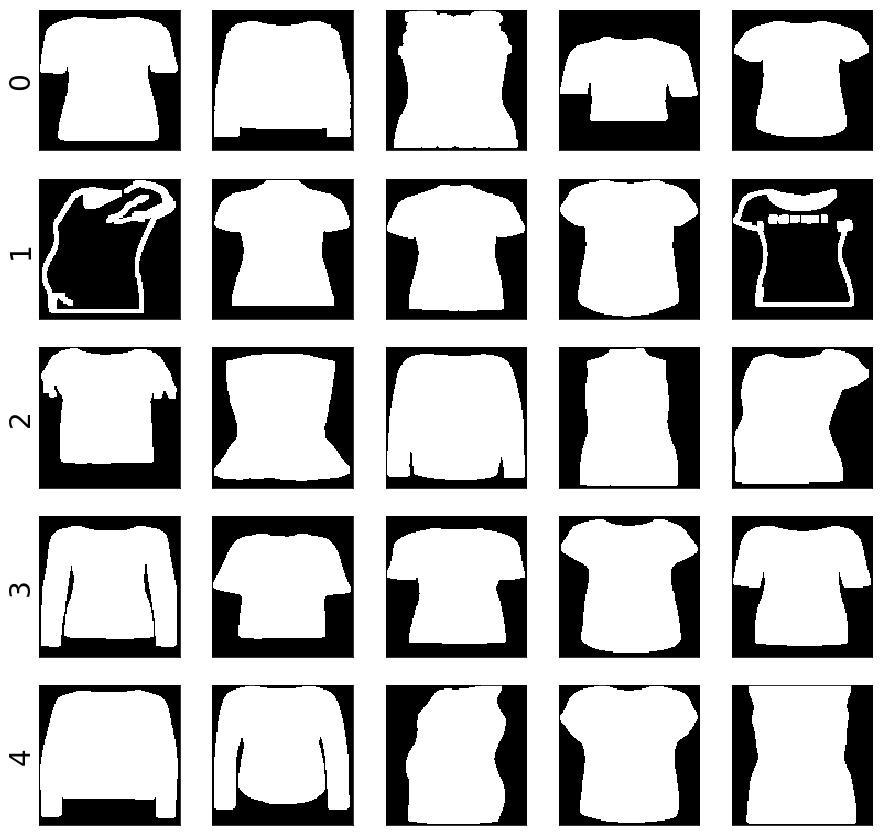

In [42]:
plt.figure(figsize=(15, 15))
for l in np.unique(labels)[1:]:
    indices = np.where(labels == l)[0]
    j = -1
    for i in range(5):
        j += 1
        plt.subplot(5, 5, 5 * l + i + 1)
        if i == 0:
            plt.ylabel('{}'.format(l), fontsize=28)
        while j < len(indices) and all_set[indices[j]] is None:
            j +=1
        plt.imshow(all_set[indices[j]][1].cpu().data.numpy()[0])
        if j == len(indices):
            break
        plt.xticks([], [])
        plt.yticks([], [])
    if l == 4:
        break
plt.show()